<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.



1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

In [3]:
# 1.1. imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection

In [6]:
# 1.2. data loading
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((331, 10), (331,), (111, 10), (111,))

In [97]:
# 1.3. ADA-boost functions

def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

def bias(y, z):
    return (y - z)


def stochastic_batch(X_train, y_train, batch_size): # функция для SGD sampling
    if 0 < batch_size < 1:
        batch_size = int(len(y_train) * batch_size)
    elif batch_size < len(y_train):
        batch_size = int(batch_size)
    else:
        print('wrong batch size')
        return None
    bootstrap_index = np.random.choice(range(len(y_train)), batch_size, replace=True)
    X_train_batch = X_train[bootstrap_index]
    y_train_batch = y_train[bootstrap_index]
    return X_train_batch, y_train_batch    
    
    

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta,
          use_SGD=False, batch_size=None): # добавлены модификации для SGD
    
    trees = []
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if use_SGD:
            X_train_fit, y_train_fit = stochastic_batch(X_train, y_train, batch_size=batch_size)
        else:
            X_train_fit, y_train_fit = X_train, y_train
        if len(trees) == 0:
            tree.fit(X_train_fit, y_train_fit)
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            target = gb_predict(X_train_fit, trees, coefs, eta)
            tree.fit(X_train_fit, bias(y_train_fit, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
        
    return trees, train_errors, test_errors

def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')
    
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

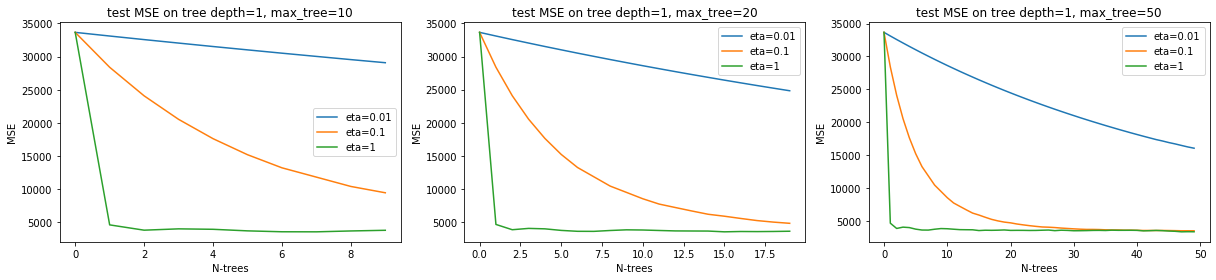

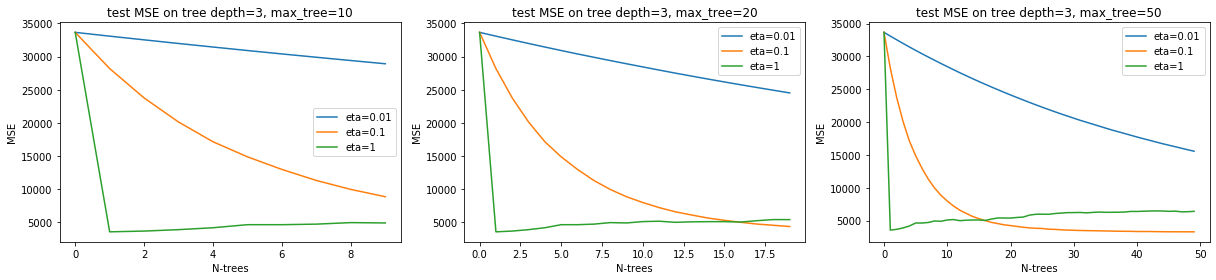

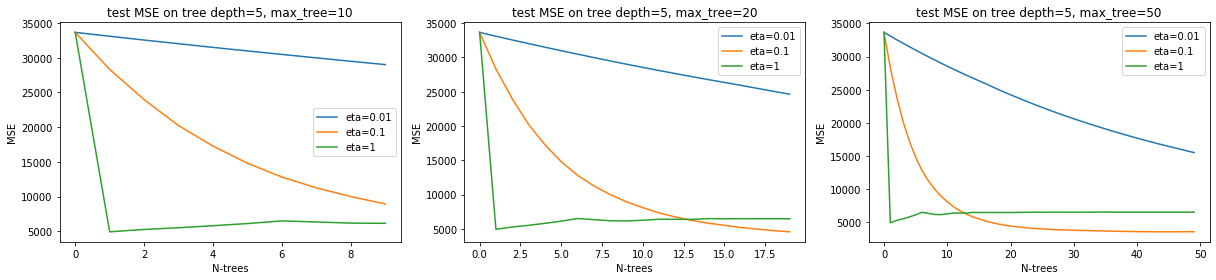

In [54]:
# 1.4. Analysis
# запуск ячейки займет около 30 мин

eta_range = [1e-2, 1e-1, 1]
n_tree_range = [10, 20, 50]
depth_range = [1, 3, 5]

for d in depth_range:
    fig, ax = plt.subplots(1,3, figsize=(17,4))
    for idx, nt in enumerate(n_tree_range):
        coefs = [1]*nt
        ax[idx].set_title(f'test MSE on tree depth={d}, max_tree={nt}')
        ax[idx].set_xlabel('N-trees')
        ax[idx].set_ylabel('MSE')
        for eta in eta_range:
            trees, train_errors, test_errors = gb_fit(nt, d, X_train, X_test, y_train, y_test, coefs, eta)
            ax[idx].plot(range(nt), test_errors, label=f'eta={eta}')
        ax[idx].legend(loc='best')
    plt.tight_layout()   

Выводы:
- для "пеньковых деревьев" - достаточно малого кол-ва деревьев (6) и высокой скорости обучения (1)
- для деревьев глубиной 3 и 5 - оптимальное кол-во деревьев в диапазоне 40-50, скорость - 0.1
- низкая скорость обучения (0,01) - не оптимальна во всех вариантах данной задачи

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. 
    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

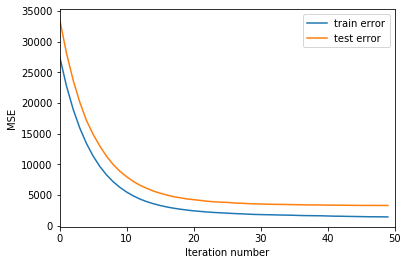

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1406.6616077890476
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3288.079984050522


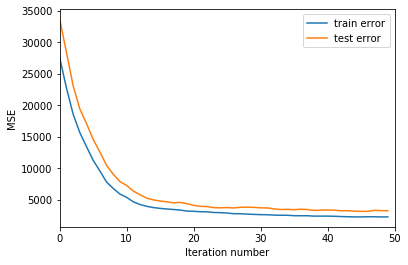

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 2318.9235306396963
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3256.476882396626


In [99]:
# Тестовый запуск стохастического варианта

# let's fix optimal params
eta = 0.1
n_tree_num = 50
tree_depth = 3
coefs = [1] * n_tree_num

# basic model - without stochastic bagging
trees, train_errors, test_errors = gb_fit(n_tree_num, tree_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_tree_num, train_errors, test_errors)
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees=n_tree_num, max_depth=tree_depth)

# stoch.model - batch size = 0.1
trees, train_errors, test_errors = gb_fit(n_tree_num, tree_depth, X_train, X_test, y_train, y_test, coefs, eta,
                                         use_SGD=True, batch_size=0.1)
get_error_plot(n_tree_num, train_errors, test_errors)
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees=n_tree_num, max_depth=tree_depth)

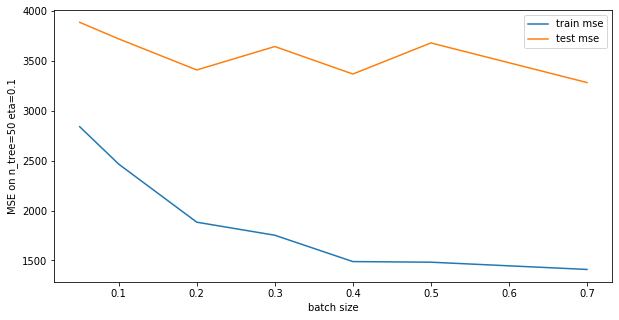

In [101]:
# Зависимость MSE vs Batch Size
# запуск ячейки займет около 15 мин

batch_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
train_mse, test_mse = [], []

for batch_size in batch_list:
    trees, train_errors, test_errors = gb_fit(n_tree_num, tree_depth, X_train, X_test, y_train, y_test, 
                                              coefs, eta, use_SGD=True, batch_size=batch_size)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_mse.append(mean_squared_error(y_train, train_prediction))
    test_mse.append(mean_squared_error(y_test, test_prediction))

plt.figure(figsize=(10,5))
plt.xlabel('batch size')
plt.ylabel(f'MSE on n_tree={n_tree_num} eta={eta}')
plt.plot(batch_list, train_mse, label='train mse')
plt.plot(batch_list, test_mse, label='test mse')
plt.legend(loc='upper right')
plt.show()
